#### Created by Andrew Stephens on 7/10/2023

## Imports

In [96]:
# Read in imports
import pandas as pd
import numpy as np
import plotly.express as px
import random
import seaborn as sns
import sklearn
from sklearn.preprocessing import scale, StandardScaler, normalize, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, log_loss, brier_score_loss, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import skopt
import matplotlib.pyplot as plt
from skopt import plots
import dataframe_image as dfi


# Give update on pipeline progress
print('All packages successfully imported.\n')

All packages successfully imported.



In [97]:
# Read in dataset
PATH = "bank-additional-full.csv"
df = pd.read_csv(PATH, delimiter=";") #, header=None

# Change "y" variable to the class "label" and code it as a binary varibale
df['label']=df['y'].astype('category').cat.codes
df.drop(['y'],axis=1,inplace=True)

# Give update on pipeline progress
print('Data successfully loaded.\n')

Data successfully loaded.



In [98]:
# Check the dependent variable value counts- this dataset is unbalanced
print('The value counts for the dependent variable are as follows:')
print(df['label'].value_counts(),'\n')

The value counts for the dependent variable are as follows:
0    36548
1     4640
Name: label, dtype: int64 



## Data Preprocessing

In [99]:
# Begin data preprocessing
print('***DATA PREPROCESSING***\n')

***DATA PREPROCESSING***



In [100]:
# Check for NAs
if df.isnull().any().any()==True:
    print('The dataset contains missing data. Fix via imputation, interpolation, deletion, etc before continuing.\n')
else:
    print('There is no missing data. Continue to the next step.\n')

There is no missing data. Continue to the next step.



In [101]:
# Feature Selection
print('Start of feature selection- first univariate selection, second multicolinearity check.\n')

# Separate X and Y matrices
y = df['label']
X = df.copy()
X.drop(['label'],axis=1,inplace=True)

# Create list of categorical variables and loop through each to assign numeric values for feature selction
cat_vars = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for i in cat_vars:
    X[i] = X[i].astype('category').cat.codes

# Apply SelectKBest to extract top features via F-score ANOVA for univariate selection
bestfeatures = SelectKBest(score_func=f_classif,k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Create dataframe with variables and their respective scores
features = pd.concat([dfcolumns,dfscores],axis=1)
features.columns = ['Variable','Score']

# Update the user with all the features and their score ranking
print('The following is a list of all dataset features ranked by their univariate score:\n')
print(features.nlargest(20,'Score'),'\n')

# We will only use the top 10 features, so a score of 400 is the cutoff
for var in range(len(features)):
    if features.Score[var] < 400:
        df.drop([features.Variable[var]],axis=1,inplace=True)
print('Only the top 10 features are kept for correlation assessment.\n')

Start of feature selection- first univariate selection, second multicolinearity check.

The following is a list of all dataset features ranked by their univariate score:

          Variable        Score
10        duration  8094.101634
19     nr.employed  5926.610601
12           pdays  4861.173272
18       euribor3m  4309.479048
15    emp.var.rate  4023.829925
13        previous  2304.257088
7          contact   881.707070
16  cons.price.idx   778.589795
14        poutcome   705.678164
4          default   410.590785
11        campaign   182.156673
3        education   138.051756
17   cons.conf.idx   124.409975
2          marital    88.107047
0              age    38.094659
1              job    26.009865
9      day_of_week    10.503096
5          housing     5.496653
8            month     1.514940
6             loan     0.992371 

Only the top 10 features are kept for correlation assessment.



Text(0, 0.5, 'F-Score')

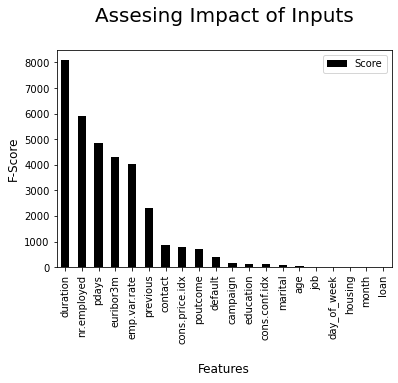

In [102]:
# Plot Feature F-Scores
features = features.sort_values(by=['Score'],ascending=False)
features.plot(kind="bar",x='Variable',color=['black'],label='F-Score')
plt.title("Assesing Impact of Inputs\n",fontsize=20)
plt.xlabel("\nFeatures",fontsize=12)
plt.ylabel("F-Score",fontsize=12)

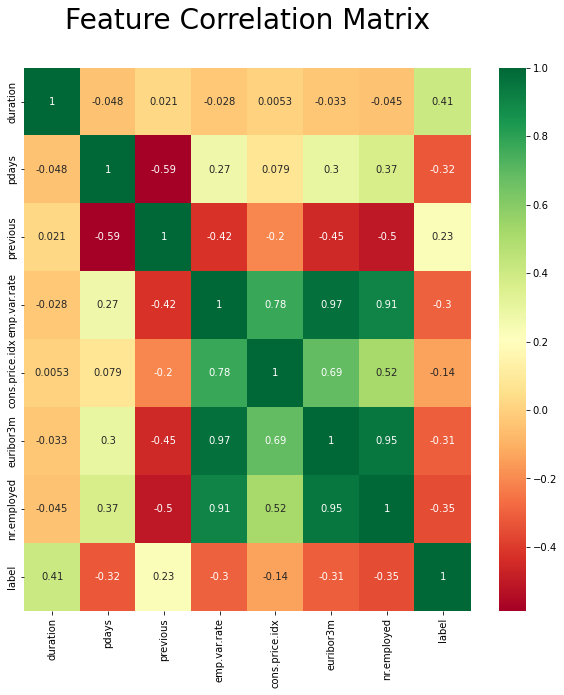

In [103]:
# Creating a correlation matrix to check for any correlated variables, an correlation greater than 0.9 will result in variables being removed

# Create correlation matrix
corrmat = df.corr()
feature_corr = corrmat.index
plt.figure(figsize=(10,10))
plt.title('Feature Correlation Matrix\n',fontsize=28)

# Plot heat map
g=sns.heatmap(df[feature_corr].corr(),annot=True,cmap="RdYlGn")

In [104]:
# emp.var.rate and euribor3m are heavily correlated with each other and a couple other variables, so we will remove both
df.drop(['emp.var.rate','euribor3m'],axis=1,inplace=True)

print('\nTwo varibales (emp.var.rate and euribor3m) are heavily correlated with each other and some additional variables.\nThese variables are removed to avoid multicolinearity from affecting the models.\n')


Two varibales (emp.var.rate and euribor3m) are heavily correlated with each other and some additional variables.
These variables are removed to avoid multicolinearity from affecting the models.



In [105]:
# The next step in the pipeline is to check for outliers
print('An outlier check is now conducted on the numeric variables.\n')

# Create new dataset that will not contain any "outliers"
df_sans_outliers = df.copy()

# Define new function to test for outliers using the interquartile range of each variable and remove those data points from the dataset
def find_outliers_IQR(df_sans_outliers,feature):
    q1 = np.quantile(df_sans_outliers[feature], 0.25)
    q3 = np.quantile(df_sans_outliers[feature], 0.75)
    IQR = q3-q1
    new_df_sans_outliers = df_sans_outliers[(df_sans_outliers[feature]>=(q1-1.5*IQR))&((df_sans_outliers[feature]<=(q3+1.5*IQR)))]
    return new_df_sans_outliers

# Create list of numeric variables (full list commented out, list with remaining variables below)
# full list of numeric variables: num_vars = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
num_vars = ['duration','pdays','previous','cons.price.idx','nr.employed']
# Create boxplots for each numeric variable to visualize potential outliers
for col in num_vars:
    fig = px.box(df_sans_outliers, y=col,title='Boxplot of '+col+' Feature')
    fig.show()
    # Make exception for pdays variable since NAs were set to 999
    if col in ['pdays']:
        pass
    else:
        df_sans_outliers = find_outliers_IQR(df_sans_outliers,col)
df_sans_outliers = df_sans_outliers.reset_index(drop=True)

An outlier check is now conducted on the numeric variables.



Ultimately, I see no reason to remove outliers as most feature distributions are skewed and no singular data point is adding unecessary weight to future models. Keeping these "outliers" actually assists the model in drawing boundaries between classes. Additionally, more "positive" data points (i.e. the respondent suscribed to the bank, label=1) are kept in the dataset resulting in a higher overall proportion than the dataset without outliers

In [106]:
print('There boxplots contain no real surprises.\nNot all variables are normally distrbuted and some observations are outside the interquartile range,\nbut none so egregiously they warrant removal.\n')

There boxplots contain no real surprises.
Not all variables are normally distrbuted and some observations are outside the interquartile range,
but none so egregiously they warrant removal.



In [107]:
# Now using the original dataset, we one hot encode the categorical varibles
features = df.copy()
features.drop(['label'],axis=1,inplace=True)
# Creating new dummy variables for each category with each variable
for col in features:
    # Looping through the columns and comparing to the numeric variable list to determine the categorical variables
    if col not in num_vars:
        ohe_features = pd.get_dummies(features[col],prefix=col)
        features = pd.concat([features,ohe_features],axis=1)
        features.drop([col],axis=1,inplace=True)
        
df = pd.concat([features,df['label']],axis=1)

print('Features have been one hot encoded.\n')

Features have been one hot encoded.



In [108]:
# Lastly, split the datasets into training and testing subsets

# set global variable for 80-20 split between training/validation and training/testing datasets going forward
test_size = 0.2

# Spliting dataset into training and testing datasets, then retrieve the X and Y datasets from the testing data
training_df, testing_df = train_test_split(df, test_size=test_size)

Y_test = testing_df['label']
testing_df.drop(['label'],axis=1,inplace=True)
X_test = testing_df.copy()

print('Training and testing datasets have been created.\n')

Training and testing datasets have been created.



C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Model Building

In [109]:
# Begin moel building
print('***MODEL BUILDING***\n')

***MODEL BUILDING***



In [110]:
# Begin building models - random forest, logistic regression, and naive bayes

# Define dataprep function to handle dataset splitting for all models
def dataprep(data,test_size):
    
    predictors = data.drop(['label'],axis=1).values
    response = data.label.values

    X_train, X_test, Y_train, Y_test = train_test_split(predictors,response,test_size=test_size)
    
    # Return training and validation sets
    return X_train, X_test, Y_train, Y_test

In [111]:
# Define and function for model optimization through hyperparameter tuning
def optimize_model(model,hyperparams,X_train,Y_train,X_test,Y_test):
    # Using Bayes Search CV as the optimization function
    opt = skopt.BayesSearchCV(
        model,
        hyperparams,
        n_iter=50,
        cv=3,
        # using the f1_macro metric for hyperparameter selection as it factors in true positives in both classes
        scoring='neg_brier_score'#'accuracy'#'f1_macro'
    )
    
    # Fit the training data to the optimized model
    opt.fit(X_train, Y_train)
    print("Best Training F-Score:", abs(opt.best_score_))
    print("Best Validation F-Score:", abs(opt.score(X_test, Y_test)))
    
    # display optimizer results for hyperparameters
    plots.plot_evaluations(opt.optimizer_results_[0])
    plt.show()
    
    optimized_params = opt.best_params_
    
    return optimized_params


Method: Random Forest



C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Best Training F-Score: 0.05727656113228651
Best Validation F-Score: 0.05992199610293002


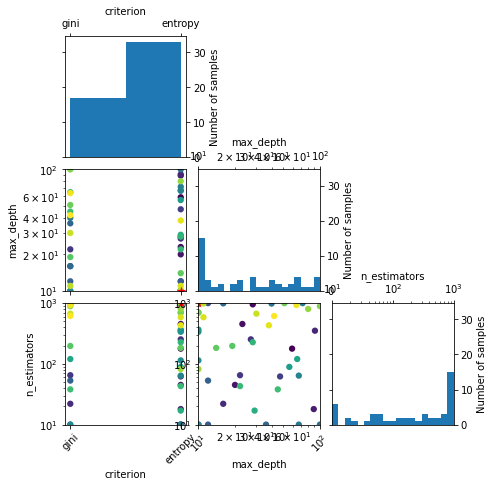

Random Forest optimized hyperparameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 10), ('n_estimators', 1000)]) 

[[5626  208]
 [ 351  405]]
0.9151745068285281
percentage Accuracy :  91.51745068285281


precision    recall  f1-score      support
0              0.941275  0.964347  0.952671  5834.000000
1              0.660685  0.535714  0.591673   756.000000
accuracy       0.915175  0.915175  0.915175     0.915175
macro avg      0.800980  0.750031  0.772172  6590.000000
weighted avg   0.909086  0.915175  0.911258  6590.000000

In [112]:
# Create Random Forest Function
def random_forest(data):
    print("\nMethod: Random Forest\n")
    
    # Initialize model
    model = RandomForestClassifier()
    
    # Retrieve train/validation data and list potential hyperparamters
    X_train, X_valid, Y_train, Y_valid = dataprep(data=data,test_size=test_size)
    hyperparams = {'n_estimators': (10, 1000,'log-uniform'),'criterion': ['gini','entropy'],'max_depth': (10,100,'log-uniform')}
    
    # Optimize hyperparameters
    RF_params = optimize_model(model,hyperparams,X_train,Y_train,X_valid,Y_valid)
    print('Random Forest optimized hyperparameters:',RF_params,'\n')
    
    # Build final model with optimized hyperparameters
    final_model = RandomForestClassifier(n_estimators=RF_params['n_estimators'],criterion=RF_params['criterion'],max_depth=RF_params['max_depth'])
    final_model.fit(X_train,Y_train)
    
    # Get predicted values
    Y_pred = final_model.predict(X_valid)

    # Create confusion matrix
    cm = confusion_matrix(Y_valid, Y_pred)
    print(cm)
    print(accuracy_score(Y_valid, Y_pred))
    model_pred = 100*accuracy_score(Y_valid,Y_pred)
    print('percentage Accuracy : ',model_pred)

    CR = classification_report(Y_valid,Y_pred, output_dict=True)
    CR = pd.DataFrame(CR).transpose()
    
    return final_model, CR

# Call random_forest method
RF_model, RF_cr = random_forest(training_df)
RF_cr


Method: Logistic Regression



C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means th

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means th

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means th

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means th

Best Training F-Score: 0.07226567768245896
Best Validation F-Score: 0.07221079156308433


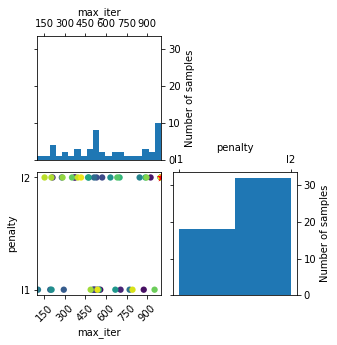

Logistic Regression optimized hyperparameters: OrderedDict([('max_iter', 1000), ('penalty', 'l2'), ('solver', 'saga')]) 

[[5739  117]
 [ 505  229]]
0.9056145675265553
percentage Accuracy :  90.56145675265553


C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



precision    recall  f1-score      support
0              0.919122  0.980020  0.948595  5856.000000
1              0.661850  0.311989  0.424074   734.000000
accuracy       0.905615  0.905615  0.905615     0.905615
macro avg      0.790486  0.646005  0.686335  6590.000000
weighted avg   0.890467  0.905615  0.890173  6590.000000

In [113]:
# Create Logistic Regression function
def logistic_regression(data):
    print("\nMethod: Logistic Regression\n")
    
    # Initialize model
    model = LogisticRegression()

    # Retrieve train/validation data and list potential hyperparamters
    X_train, X_valid, Y_train, Y_valid = dataprep(data=data,test_size=test_size)
    hyperparams = {'penalty': ['l1','l2'],'solver': ['saga'],'max_iter': (100, 1000,'uniform')}

    # Optimize hyperparameters
    LR_params = optimize_model(model,hyperparams,X_train,Y_train,X_valid,Y_valid)
    print('Logistic Regression optimized hyperparameters:',LR_params,'\n')
    
    # Build final model with optimized hyperparameters
    final_model = LogisticRegression(penalty=LR_params['penalty'],solver=LR_params['solver'],max_iter=LR_params['max_iter'])
    final_model.fit(X_train,Y_train)
    
    # Get predicted values
    Y_pred = final_model.predict(X_valid)

    # Create confusion matrix
    cm = confusion_matrix(Y_valid, Y_pred)
    print(cm)
    print(accuracy_score(Y_valid, Y_pred))
    model_pred = 100*accuracy_score(Y_valid,Y_pred)
    print('percentage Accuracy : ',model_pred)

    CR = classification_report(Y_valid,Y_pred, output_dict=True)
    CR = pd.DataFrame(CR).transpose()
    
    return final_model, CR

# Call logistic_regression method
LR_model, LR_cr = logistic_regression(training_df)
LR_cr


Method: Naive Bayes



C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

C:\Users\16036\Anaconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Best Training F-Score: 0.08047604252764474
Best Validation F-Score: 0.08101946005844146


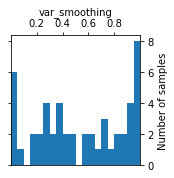

Naive Bayes optimized hyperparameters: OrderedDict([('var_smoothing', 1.0)]) 

[[5739  107]
 [ 538  206]]
0.9021244309559939
percentage Accuracy :  90.2124430955994


precision    recall  f1-score      support
0              0.914290  0.981697  0.946795  5846.000000
1              0.658147  0.276882  0.389782   744.000000
accuracy       0.902124  0.902124  0.902124     0.902124
macro avg      0.786219  0.629289  0.668289  6590.000000
weighted avg   0.885372  0.902124  0.883910  6590.000000

In [114]:
# Create Naive Bayes function
def naive_bayes(data):
    print("\nMethod: Naive Bayes\n")

    # Initialize model
    model = GaussianNB()
    
    # Retrieve train/validation data and list potential hyperparamters
    X_train, X_valid, Y_train, Y_valid = dataprep(data=data,test_size=test_size)
    hyperparams = {'var_smoothing': (1e-20, 1.0, 'uniform')}
    
    # Optimize hyperparameters
    NB_params = optimize_model(model,hyperparams,X_train,Y_train,X_valid,Y_valid)
    print('Naive Bayes optimized hyperparameters:',NB_params,'\n')
    
    # Build final model with optimized hyperparameters
    final_model = GaussianNB(var_smoothing=NB_params['var_smoothing'])
    final_model.fit(X_train,Y_train)
    
    # Get predicted values
    Y_pred = final_model.predict(X_valid)

    # Create confusion matrix
    cm = confusion_matrix(Y_valid, Y_pred)
    print(cm)
    print(accuracy_score(Y_valid, Y_pred))
    model_pred = 100*accuracy_score(Y_valid,Y_pred)
    print('percentage Accuracy : ',model_pred)

    CR = classification_report(Y_valid,Y_pred, output_dict=True)
    CR = pd.DataFrame(CR).transpose()
    
    return final_model, CR

# Call naive bayes method
NB_model, NB_cr = naive_bayes(training_df)
NB_cr

## Model Testing and Evaluation

In [115]:
# Begin model testing and evaluation
print('***MODEL TESTING AND EVALUATION***\n')

***MODEL TESTING AND EVALUATION***



In [116]:
# Final Testing

# Defining a model_testing function to assess the final models based on relavant metrics
def model_testing(model,X_test,Y_test):
    
    # Classify data based on test data
    Y_pred = model.predict(X_test)
    
    # Create confusion matrix for test data
    cm = confusion_matrix(Y_test, Y_pred)
    print(cm)
    print(accuracy_score(Y_test, Y_pred))
    model_pred = 100*accuracy_score(Y_test,Y_pred)
    print('percentage Accuracy : ',model_pred,'\n')

    CR = classification_report(Y_test,Y_pred, output_dict=True)
    CR = pd.DataFrame(CR).transpose()
    
    # Get f-score
    f1_racing = f1_score(Y_test,Y_pred)
    
    # Get classification probabilities
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    
    # Calculate log loss
    log = log_loss(Y_test, probs)
    
    # Calculate brier score
    brier = brier_score_loss(Y_test, probs)
    
    # Calculate ROC-AUC
    roc_auc = roc_auc_score(Y_test, probs)
    
    # Create list of metrics to return
    metric_list = [model_pred,f1_racing,log,brier,roc_auc]
    
    return metric_list

# Use test data on final model selections and retrieve metrics for each model type
print('RF results:\n')
RF_metrics = model_testing(model=RF_model,X_test=X_test,Y_test=Y_test)
print('LR results:\n')
LR_metrics = model_testing(model=LR_model,X_test=X_test,Y_test=Y_test)
print('NB results:\n')
NB_metrics = model_testing(model=NB_model,X_test=X_test,Y_test=Y_test)

RF results:

[[7009  277]
 [ 458  494]]
0.9107793153678078
percentage Accuracy :  91.07793153678078 

LR results:

[[7123  163]
 [ 667  285]]
0.8992473901432386
percentage Accuracy :  89.92473901432386 

NB results:

[[7108  178]
 [ 705  247]]
0.8928137897547949
percentage Accuracy :  89.28137897547948 



In [117]:
# Creating dataframe of final metrics for comparison
metrics = [RF_metrics,LR_metrics,NB_metrics]
metrics_df = pd.DataFrame(metrics,index=['Random Forest','Logistic Regression','Naive Bayes'],columns=['Accuracy','F_Score','Log Loss','Brier Score','ROC-AUC'])
print(metrics_df)

                      Accuracy   F_Score  Log Loss  Brier Score   ROC-AUC
Random Forest        91.077932  0.573418  0.186903     0.060023  0.940907
Logistic Regression  89.924739  0.407143  0.263849     0.076915  0.879930
Naive Bayes          89.281379  0.358751  0.309001     0.087621  0.896050


In [118]:
# Highlighting the best metrics across the various models
final_metrics = metrics_df.style.highlight_max(subset=['Accuracy','F_Score','ROC-AUC']).highlight_min(subset=['Log Loss','Brier Score'])
final_metrics

Text(0, 0.5, 'Model Accuracy')

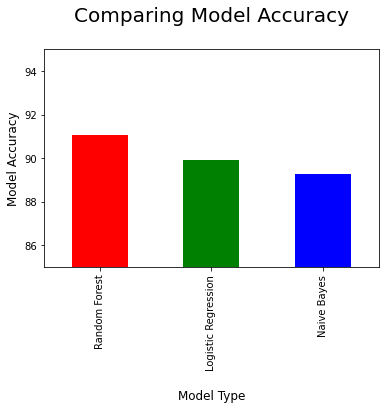

In [119]:
# Plot accuracies

metrics_df['Accuracy'].plot(kind="bar",color=['red','green','blue'])
plt.ylim(85,95)
plt.title("Comparing Model Accuracy\n",fontsize=20)
plt.xlabel("\nModel Type",fontsize=12)
plt.ylabel("Model Accuracy",fontsize=12)

Text(0, 0.5, 'Brier Score (lower is better)')

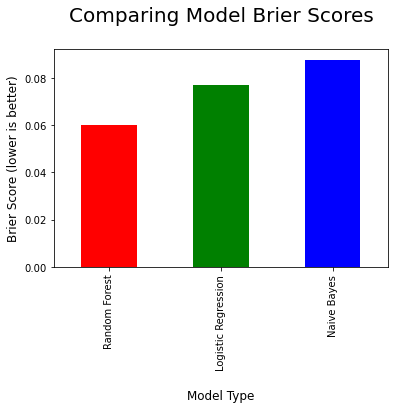

In [120]:
# Plot Brier Scores

metrics_df['Brier Score'].plot(kind="bar",color=['red','green','blue'])
plt.title("Comparing Model Brier Scores\n",fontsize=20)
plt.xlabel("\nModel Type",fontsize=12)
plt.ylabel("Brier Score (lower is better)",fontsize=12)

In [121]:
print('Random Forest was determined to be the best model for predicting successful bank marketing calls.')

Random Forest was determined to be the best model for predicting successful bank marketing calls.
